In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from transformers import AddTime, LeadLag
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.io import arff
import torch
import time 
import iisignature
from tools import *
from sigKernel import sig_kernel, covariance_train, covariance_test

In [5]:
data_train = arff.loadarff('Multivariate2018_arff/Multivariate_arff/ArticularyWordRecognition/ArticularyWordRecognition_TRAIN.arff')
data_test = arff.loadarff('Multivariate2018_arff/Multivariate_arff/ArticularyWordRecognition/ArticularyWordRecognition_TEST.arff')

df_train = pd.DataFrame(data_train[0]).iloc[::5,:]
df_test = pd.DataFrame(data_test[0]).iloc[::5,:]

labels_train = df_train.iloc[:,1]
labels_test = df_test.iloc[:,1]

y_train = LabelEncoder().fit_transform(labels_train)
y_test = LabelEncoder().fit_transform(labels_test)

x_train = [np.array(a.tolist()).T for a in df_train.iloc[:10,0]]
x_test = [np.array(a.tolist()).T for a in df_test.iloc[:10,0]]

In [4]:
df_train.activity.unique()

array([b'EPILEPSY', b'WALKING', b'RUNNING', b'SAWING'], dtype=object)

In [5]:
def transform(paths):
#     paths = LeadLag().fit_transform(paths)
#     paths = AddTime().fit_transform(paths)
#     derivatives = [np.diff(p,axis=0) for p in paths]
#     derivatives = [d/d.max() for d in derivatives]
#     paths = [d.cumsum(0) for d in derivatives]
#     return [p/p.max() for p in paths]
    return paths

In [6]:
scale = 0.1
x_train = scale*np.array(transform(x_train))
x_test = scale*np.array(transform(x_test))
l = x_train.shape[1]

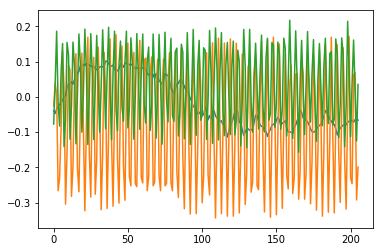

In [7]:
plt.plot(x_train[1])
plt.show()

In [8]:
x_train.shape

(28, 206, 3)

In [9]:
x_test.shape

(28, 206, 3)

In [10]:
np.unique(y_train)

array([0, 1, 2, 3])

In [17]:
n = 0

In [20]:
# x_final = np.concatenate((x_train, x_test), 0)
# CC = covariance_train(x_final, n)
# train_indeces = np.arange(len(x_train))
# test_indeces = np.arange(len(x_train), len(x_train)+len(x_test))
# y_final = np.concatenate((y_train, y_test)).reshape(-1,1)
# experiment_precomputed(CC, y_final, train_indeces, test_indeces, param_init=[0,0,0],
#                        RBF=False, plot=False, device=torch.device("cpu"))

In [21]:
gram_matrix = covariance_train(x_train, n)

[Parallel(n_jobs=56)]: Done   7 out of  28 | elapsed:    5.5s remaining:   16.6s
[Parallel(n_jobs=56)]: Done  13 out of  28 | elapsed:    9.9s remaining:   11.4s
[Parallel(n_jobs=56)]: Done  19 out of  28 | elapsed:   13.9s remaining:    6.6s
[Parallel(n_jobs=56)]: Done  25 out of  28 | elapsed:   17.2s remaining:    2.1s
[Parallel(n_jobs=56)]: Done  28 out of  28 | elapsed:   18.9s finished


In [22]:
test_matrix = covariance_test(x_train, x_test, n)

[Parallel(n_jobs=56)]: Done   7 out of  28 | elapsed:   21.6s remaining:  1.1min
[Parallel(n_jobs=56)]: Done  13 out of  28 | elapsed:   21.7s remaining:   25.1s
[Parallel(n_jobs=56)]: Done  19 out of  28 | elapsed:   22.0s remaining:   10.4s
[Parallel(n_jobs=56)]: Done  25 out of  28 | elapsed:   22.2s remaining:    2.7s
[Parallel(n_jobs=56)]: Done  28 out of  28 | elapsed:   22.2s finished


In [23]:
results_penalty = []
for p in np.linspace(0.01, 2000, 50):
    clf = SVC(C=p, kernel='precomputed', decision_function_shape='ovo', gamma='auto')
    clf.fit(gram_matrix, y_train)
    predictions = clf.predict(test_matrix)
    results_penalty.append(accuracy_score(predictions, y_test))

In [24]:
# plt.plot(results_penalty)

In [25]:
final_results = {}

# standard kernels
for ker in ['linear', 'poly', 'rbf']:
    clf = SVC(C=2000, kernel=ker, decision_function_shape='ovo', gamma='auto')
    clf.fit([c.reshape(-1) for c in x_train], y_train)
    predictions = clf.predict([c.reshape(-1) for c in x_test])
    final_results[ker] = accuracy_score(predictions, y_test)
    
# signature naive kernel
clf = SVC(C=2000, kernel='linear', decision_function_shape='ovo', gamma='auto')
clf.fit([iisignature.sig(c,4) for c in x_train], y_train)
predictions = clf.predict([iisignature.sig(c,4) for c in x_test])
final_results['sig-naive'] = accuracy_score(predictions, y_test)

final_results['sig-PDE'] = max(results_penalty)

In [26]:
pd.DataFrame.from_dict(final_results, orient='index').rename(columns={0:'accuracy (%)'})

,accuracy (%)
linear,0.464286
poly,0.285714
rbf,0.464286
sig-naive,0.607143
sig-PDE,0.821429
